In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import cv2

In [2]:
TRANSFORMS = transforms.Compose([
    transforms.ElasticTransform(alpha=125.0), 
    transforms.RandomRotation(15), 
    transforms.RandomHorizontalFlip()
    #maybe some more
])

In [3]:
data = pd.read_csv('./results.csv', sep='|')
print(data.shape)
data.head()

(158915, 3)


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [4]:
# column names have spaces in the beginning for some reason
# (plolly cause the seperator is '|' and not space)
data.rename(columns={' comment_number': 'comment_number',
            ' comment': 'comment'}, inplace=True)
# there was one empty comment
data.dropna(inplace=True)

In [5]:
import re
def remove_non_alpha(s: str):
    s = s.lower()
    s = re.sub(r'[^\w\s]', '', s)
    return s

In [6]:
data['comment'] = data['comment'].apply(remove_non_alpha)
data['comment'].values

array([' two young guys with shaggy hair look at their hands while hanging out in the yard ',
       ' two young  white males are outside near many bushes ',
       ' two men in green shirts are standing in a yard ', ...,
       ' a man is leaning off of the side of a blue and white boat as it sits in a body of water ',
       ' a man riding a small boat in a harbor  with fog and mountains in the background ',
       ' a man on a moored blue and white boat with hills and mist in the background '],
      dtype=object)

In [7]:
# forming a dictionary for the model
from collections import Counter

words = Counter()
for sent in data['comment'].values:
    for word in sent.split():
        words[word] +=1


In [8]:
print(len(words))

20007


In [9]:
MAX_DICTIONARY_LENGTH = 15000
most_common = words.most_common(MAX_DICTIONARY_LENGTH)
# is the threshold needed?
dictionary = pd.DataFrame(
    {'word': [i[0] for i in most_common if i[1] >= 10], 'count': [i[1] for i in most_common if i[1] >= 10]})

In [10]:
dictionary.shape

(5461, 2)

In [11]:
class my_lstm(nn.Module):
    # gotta get rid of this later, the experiment was fine enough
    def __init__(self, input_size, hidden_size,  *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.hidden = torch.rand(hidden_size)
        self.cell_state = torch.rand(hidden_size)

        self.forget_gate = nn.Sequential(
            nn.Linear(hidden_size+input_size, hidden_size),
            nn.Sigmoid()
        )
        self.input_gate = nn.Sequential(
            nn.Linear(hidden_size+input_size, hidden_size),
            nn.Sigmoid()
        )
        self.cell_gate = nn.Sequential(
            nn.Linear(hidden_size+input_size, hidden_size),
            nn.Tanh()
        )
        self.output_gate = nn.Sequential(
            nn.Linear(hidden_size+input_size, hidden_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        hx = torch.concat((x, self.hidden))
        self.cell_state *= self.forget_gate(hx)
        self.cell_state += self.cell_gate(hx)*self.input_gate(hx)
        out = torch.tanh(self.cell_state) * self.output_gate(hx)
        self.hidden = out
        return out

In [33]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/lopharb/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-4 Python-3.11.5 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


tensor([[6.33230e+02, 5.75677e+01, 8.56937e+02],
        [4.50908e+02, 6.09472e+02, 4.11176e+02],
        [1.10583e+03, 1.14536e+02, 4.78490e+02],
        [7.80398e+02, 1.82322e+02, 8.12634e+02],
        [6.69755e-01, 6.44206e-01, 3.07423e-01],
        [1.00000e+00, 2.00000e+00, 0.00000e+00]], device='cuda:0')
      xcenter     ycenter        width      height  confidence  class     name
0  633.230408  450.907776  1105.827026  780.397827    0.669755      1  bicycle
1   57.567699  609.472412   114.536232  182.321533    0.644206      2      car
2  856.937012  411.175629   478.489746  812.634216    0.307423      0   person
tensor([577988.37500,  13452.58008, 119537.60156], device='cuda:0')


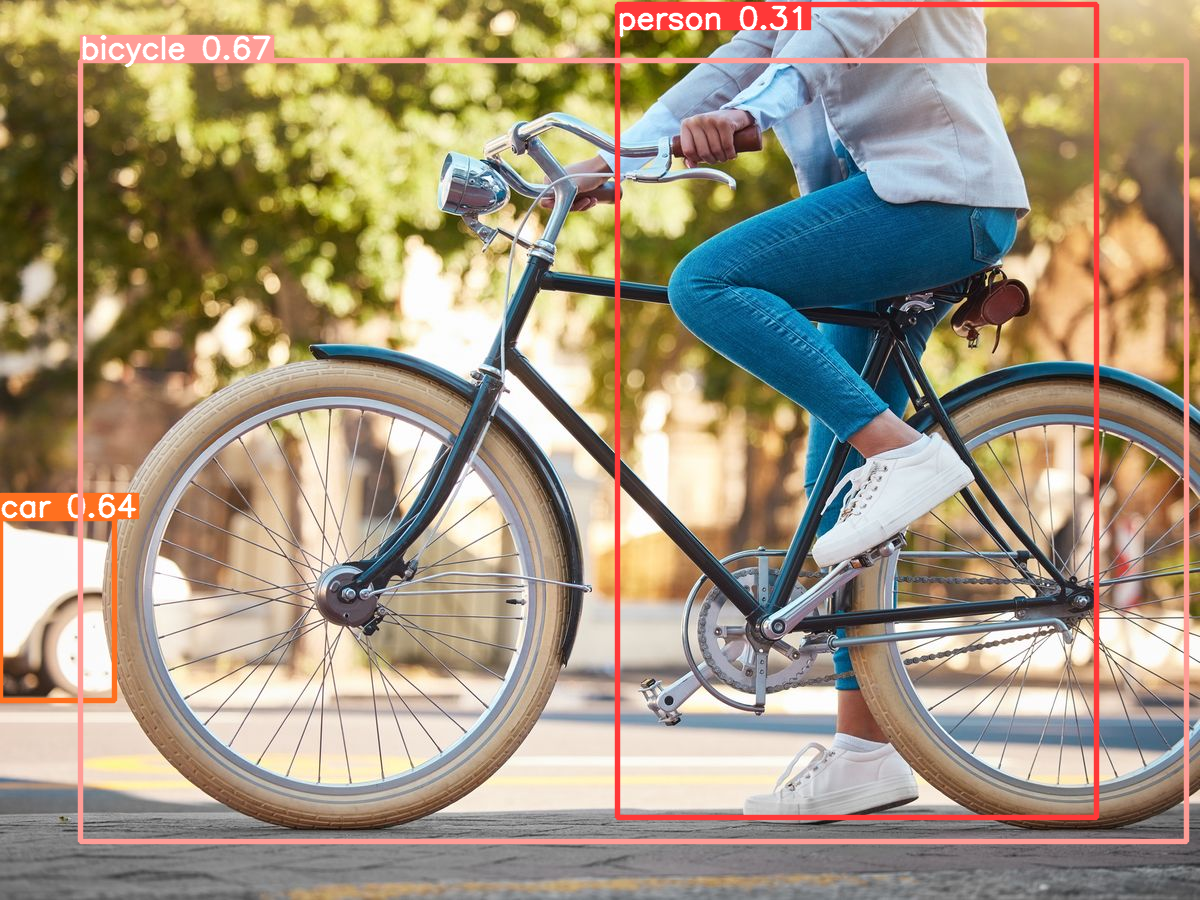

In [45]:
img = 'data/bicycle.jpg'
res = model(img)
tmp = res.xywh[0].permute(1, 0)
print(tmp)
print(res.pandas().xywh[0]) # x y width height confidence label (probably)
importances = tmp[2]*tmp[3]*tmp[4]
print(importances)
res.show()